In [1]:
import os
import numpy as np
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras import layers, models

input_dir = "/kaggle/input/cloud-cover-detection/data/train_features"
label_dir = "/kaggle/input/cloud-cover-detection/data/train_labels"
resized_images_list = []
resized_labels_list = []
for subdir in os.listdir(input_dir):
    subdir_path = os.path.join(input_dir, subdir)
    if os.path.isdir(subdir_path):
        b04_image_path = os.path.join(subdir_path, 'B04.tif')
        if os.path.exists(b04_image_path):
            with rasterio.open(b04_image_path) as src:
                data = src.read(1, out_shape=(1, 64, 64), resampling=Resampling.bilinear)
                transform = src.transform * Affine.scale(1.0 / src.width, 1.0 / src.height)
                resized_images_list.append(data)
            label_path = os.path.join(label_dir, f'{subdir}.tif')
            if os.path.exists(label_path):
                with rasterio.open(label_path) as label_src:
                    label_data = label_src.read(1, out_shape=(1, 64, 64), resampling=Resampling.bilinear)
                    label_transform = label_src.transform * Affine.scale(1.0 / label_src.width, 1.0 / label_src.height)
                    resized_labels_list.append(label_data)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
images=np.array(resized_images_list)
labels=np.array(resized_labels_list)

In [26]:
images=images/255.0
labels=labels/255.0

In [5]:
images.shape


(11748, 64, 64)

In [22]:
labels.shape

(11748, 64, 64)

In [3]:
images=images.reshape(images.shape[0],images.shape[2],images.shape[1],1)

In [27]:
labels=labels.reshape(labels.shape[0],labels.shape[2],labels.shape[1])

In [9]:
images.shape

(11748, 64, 64, 1)

In [24]:
labels.shape

(11748, 64, 64)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_vit_with_attention_maps(input_shape, num_classes, num_attention_heads):
    inputs = tf.keras.layers.Input(shape=input_shape) 
    x = layers.Flatten()(inputs)
    attention_heads = []
    for _ in range(num_attention_heads):
        attention_head = layers.Dense(1024, activation="relu")(x)
        attention_head = layers.BatchNormalization()(attention_head)
        attention_head = layers.Dense(512, activation="relu")(attention_head)
        attention_head = layers.BatchNormalization()(attention_head)
        attention_head = layers.Dense(64*64*1, activation="linear")(attention_head)  # Use linear activation for intermediate layers
        attention_head = layers.BatchNormalization()(attention_head)
        attention_head = layers.Reshape((64, 64, 1))(attention_head)  # Reshape each attention head's output
        attention_heads.append(attention_head)
    if num_attention_heads > 1:
        outputs = layers.Average()(attention_heads)  # You can use different aggregation methods (e.g., concatenate) as needed
    else:
        outputs = attention_heads[0]
    outputs = layers.Activation("sigmoid")(outputs)

    return models.Model(inputs, outputs)

input_shape = (64, 64, 1)  
num_classes = 1   #+1=2classes
num_attention_heads = 4  
custom_model = create_custom_vit_with_attention_maps(input_shape, num_classes, num_attention_heads)
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
custom_model.fit(images, labels, batch_size=64, epochs=50,validation_split=0.2)  

Epoch 1/50
147/147 [==============================] - 12s 16ms/step - loss: 0.5453 - accuracy: 0.7306 - val_loss: 0.5276 - val_accuracy: 0.7645
Epoch 2/50
147/147 [==============================] - 2s 13ms/step - loss: 0.5144 - accuracy: 0.7587 - val_loss: 0.5020 - val_accuracy: 0.7690
Epoch 3/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4978 - accuracy: 0.7679 - val_loss: 0.5047 - val_accuracy: 0.7656
Epoch 4/50
147/147 [==============================] - 2s 14ms/step - loss: 0.4861 - accuracy: 0.7742 - val_loss: 0.5102 - val_accuracy: 0.7479
Epoch 5/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4768 - accuracy: 0.7781 - val_loss: 0.5323 - val_accuracy: 0.7521
Epoch 6/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4700 - accuracy: 0.7817 - val_loss: 0.4934 - val_accuracy: 0.7677
Epoch 7/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4615 - accuracy: 0.7866 - val_loss: 0.5033 - val_accuracy: 0.767

1/1 [==============================] - 0s 19ms/step


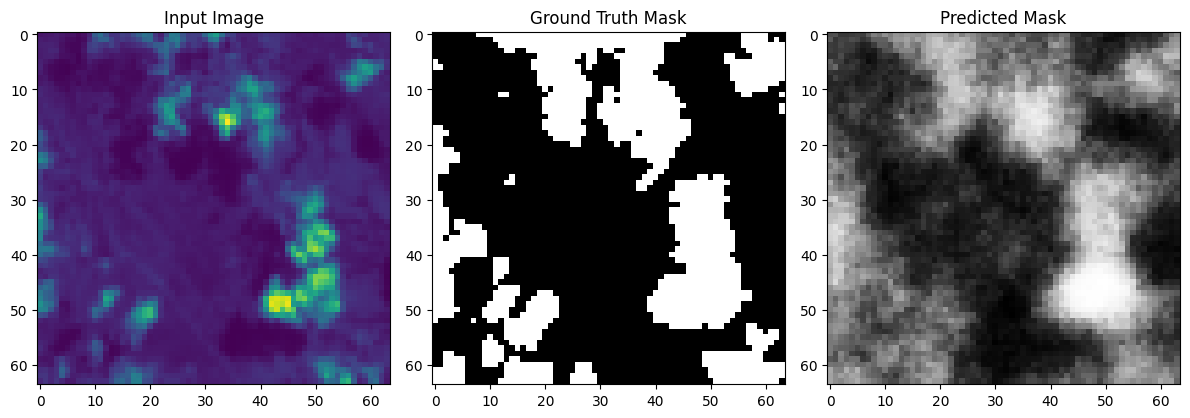

In [37]:
import random
import matplotlib.pyplot as plt
index = random.randint(0, len(images) - 1)
input_image = np.expand_dims(images[index], axis=0)  
predicted_mask = model.predict(input_image)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images[index])
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(labels[index], cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.tight_layout()
plt.show()